### This notebook contains the following operations
* Load the US Video data with Titles/Tags/Descriptions
* Create iterators for train, validation and test datasets
* Run the analysis with neural network models (including RNN, CNN, and simple Linear NN)
* Run the analysis with Machine Learning Models (logistic regression and random forest) with reduced TFIDF matrix
* Run the analysis with Logistic Regression with Bag of Words of ngrams
* Visualize the comparison of the performances

In [2]:
import data_input as data_in
import nnmodels as nnm
import mlmodels as mlm
import bow_models as bowm
import train_eval
import visualization as vis
from torchtext import data
import torch

### Load Data and Define Train, Valid, and Test Sets

In [3]:
data_dir = r'D:\Researching Data\Youtube data\USvideos.csv' # should specify the directory for US video data
path = r'D:\Researching Data\Youtube data' # should specify the directory for all video data
MAX_VOCAB_SIZE = 25000
TRAIN_VALID_TEST_R = (0.4, 0.4, 0.2)
BATCH_SIZE = 64

In [4]:
new_TEXT, new_label, new_arr = data_in.load_data(data_dir, 24, "full")
# using title, tags might be problematic for CNN models (the length of sequences)

torch.backends.cudnn.deterministic = True
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)
train_data, valid_data, test_data = data_in.build_train_test(path, new_arr, TRAIN_VALID_TEST_R, TEXT, LABEL)

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)
device = torch.device('cpu') # switch to local device 
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data_in.build_iterator(BATCH_SIZE, device, train_data, valid_data, test_data)

25.492048496299795  percent of videos are labelled as the selected category
the baseline precision is  25.492048496299795  in this model
The size of train, valid and test data are 2540 2540 1271
Number of training examples: 2539
Number of testing examples: 1270
Number of validation examples:2539


### Run Neural Network

In [5]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_wordem = nnm.WordEmbAvg_2linear(INPUT_DIM, EMBEDDING_DIM, 
                                      HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model_rnn = nnm.SimpleRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, 
                          OUTPUT_DIM, PAD_IDX)
model_BLSTM = nnm.LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                       N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model_GRU = nnm.GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                    N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
model_CNN = nnm.CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, 
                    OUTPUT_DIM, DROPOUT, PAD_IDX)
MODEL_DICT = {"avg_embedding": model_wordem, "SimpleRNN": model_rnn,
              "BLSTM": model_BLSTM, "BGRU": model_GRU, "CNN": model_CNN}

In [6]:
best_models, models_perf = train_eval.compare_models(MODEL_DICT, device, train_iterator, valid_iterator, test_iterator, 5)
train_eval.get_effective_norms(best_models, TEXT)

currently training the model:  avg_embedding
Epoch 0: Dev Accuracy: 0.7291787788271904 Dev Loss:0.5051681026816368
Epoch 1: Dev Accuracy: 0.8519803777337074 Dev Loss:0.40570568665862083
Epoch 2: Dev Accuracy: 0.8580305233597756 Dev Loss:0.5148559372872115
Epoch 3: Dev Accuracy: 0.8736555233597756 Dev Loss:0.48500312827527525
Epoch 4: Dev Accuracy: 0.8564680233597756 Dev Loss:0.5503606040030717
Test Loss: 0.450 | Test Acc: 86.91%
Test Prec: 73.769% | Test Rec: 68.968%
currently training the model:  SimpleRNN
Epoch 0: Dev Accuracy: 0.7287881538271904 Dev Loss:0.577216523885727
Epoch 1: Dev Accuracy: 0.7389444038271904 Dev Loss:0.5920673660933972
Epoch 2: Dev Accuracy: 0.7291787788271904 Dev Loss:0.5945496380329132
Epoch 3: Dev Accuracy: 0.7287881538271904 Dev Loss:0.5866742692887783
Epoch 4: Dev Accuracy: 0.7291787788271904 Dev Loss:0.665858768671751
Test Loss: 0.574 | Test Acc: 75.03%
Test Prec: nan% | Test Rec: 4.165%
currently training the model:  BLSTM
Epoch 0: Dev Accuracy: 0.729178

### Run TFIDF with Machine Learning Models

In [6]:
tfidf_path = r'D:\Researching Data\Youtube data\tfidf' # should specify the directory for video data with TFIDF
TOPK = 5000
K = 500

In [7]:
new_TEXT, new_label, new_arr = data_in.get_tfidf_matrix(data_dir, 24, "full", TOPK)
X_train, y_train, X_valid, y_valid, X_test, y_test =\
data_in.split_reduced_data(tfidf_path, new_TEXT, new_label, 
                           K, TRAIN_VALID_TEST_R)
mlm_perform = mlm.ml_evaluate(mlm.CLFS, mlm.PARAMETER_DICT, X_train, y_train, 
                              X_valid, y_valid, X_test, y_test)

the current shape of the reduced data is  (6351, 5000)
The size of train, valid and test data are 2540 2540 1271
operation of random_forest method begins
the best accuracy for method:  random_forest  is  0.8607395751376868
the corresponding precision is :  0.9675324675324676
the corresponding recall is :  0.46417445482866043
operation of logistics method begins
the best accuracy for method:  logistics  is  0.8489378442171518
the corresponding precision is :  0.9056603773584906
the corresponding recall is :  0.4485981308411215


### N-Grams and BOW Classifiers

In [8]:
new_TEXT, new_label, new_arr = data_in.load_data(data_dir, 24, "full")
train_indices, valid_indices, test_indices = data_in.split_train_test(new_arr.shape[0], TRAIN_VALID_TEST_R)

X_train_bow = new_TEXT[train_indices]
y_train_bow = new_label[train_indices]
X_valid_bow = new_TEXT[valid_indices]
y_valid_bow = new_label[valid_indices]
X_test_bow = new_TEXT[test_indices]
y_test_bow = new_label[test_indices]

word_to_idx, wtorch = bowm.word_to_index(2, new_TEXT)
dgrams = bowm.word_ngrams(2, X_train_bow)[0]
VOCAB_SIZE = len(word_to_idx)
NUM_LABELS = 2
n = 2

25.492048496299795  percent of videos are labelled as the selected category
the baseline precision is  25.492048496299795  in this model
The size of train, valid and test data are 2540 2540 1271


In [9]:
model = nnm.BoWNN(VOCAB_SIZE, NUM_LABELS)
perf_dict = bowm.run_bow_ngram(model, word_to_idx, wtorch, 
                               X_train_bow, y_train_bow, 
                               X_valid_bow, y_valid_bow, 
                               X_test_bow, y_test_bow, n)

For epoch number  0 , the accuracy for validation set is  0.8377952755905512
For epoch number  1 , the accuracy for validation set is  0.8696850393700788
For epoch number  2 , the accuracy for validation set is  0.8807086614173228
For epoch number  3 , the accuracy for validation set is  0.8740157480314961
For epoch number  4 , the accuracy for validation set is  0.8744094488188976
the accuracy for test set is  0.8662470495672698
the presision for test set is  0.75
the recall for test set is  0.703125


### Performance Visualization

In [10]:
vis.alt.renderers.enable("notebook")
EPOCH = 5

In [11]:
full_perf_df, full_perf_df2, layer_perf_df = vis.process_perf_dict(models_perf, mlm_perform, perf_dict, EPOCH)
plt1 = vis.plot_nn_performance(full_perf_df)
plt2 = vis.plot_best_model(layer_perf_df)

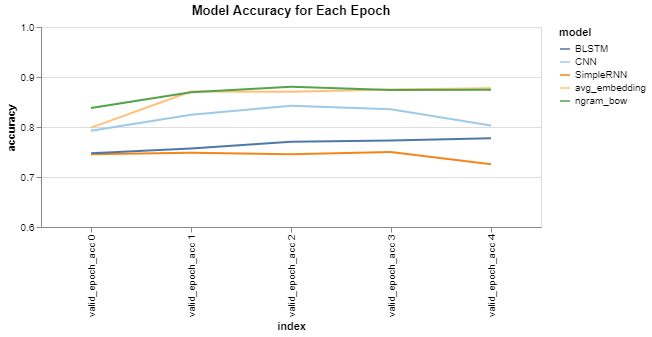

In [12]:
plt1

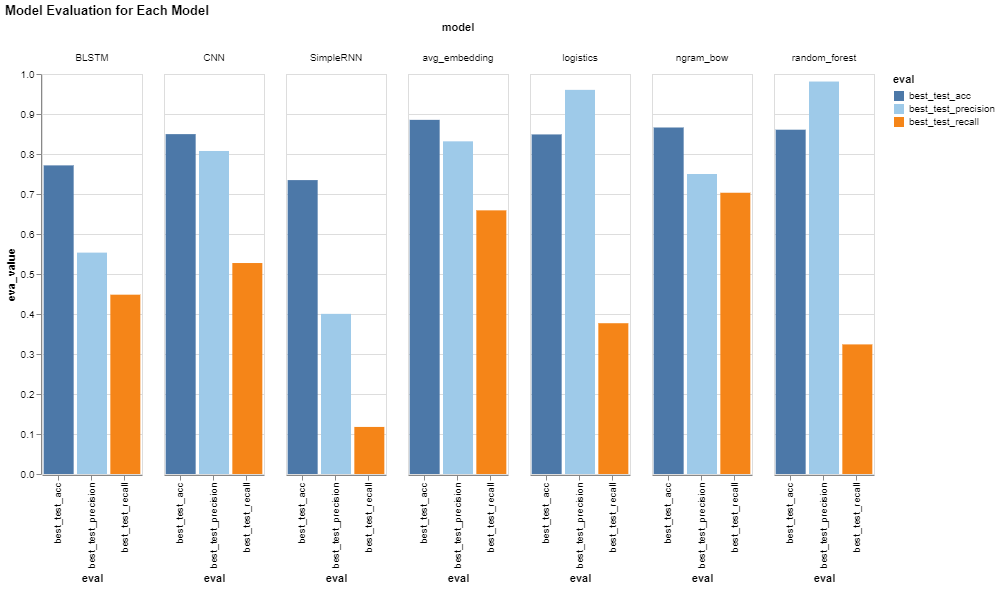

In [13]:
plt2